# EigenCAM for YOLO5

![image.png](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/yolo_eigencam.png)


In this tutorial we're going to see how to use EigenCAM (one of the gradient free methods) for YOLO5.

This is a much simpler version of the tutorial in https://github.com/jacobgil/pytorch-grad-cam/blob/master/tutorials/Class%20Activation%20Maps%20for%20Object%20Detection%20With%20Faster%20RCNN.ipynb
adapted for YOLO5.

If you wanted to use other methods like AblationCAM, you can use the other tutorial.


As a reminder from the tutorial above, we're going to use gradient free methods for object detection, since most frameworks won't support computing gradients.


We're going to use the YOLO5 model from ultralytics
``` python
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)`
```

As you recall, when adapting this library to new architectures, there are three main things you need to think about:


- **The reshape transform**. 
  This is used to get the activations from the model and process them so they are in 2D format.
  Sometimes the layers will not output tensors, for example, but tuples of tensors. 
  So we need a function that knows to dig into the output and find our 2D activation.

    In the case of YOLO5, no need for this, we're getting a 2D spatial tensor.


- **The target function** that guides our class activation map.

  In the case of EigenCAM, there is no target function. We're going to do PCA on the 2D activations.

  If we would use another method like AblationCAM we would need this, and then you can look at the faster-rcnn tutorial above.


- **The target layer** to extract the 2D activations from. We're going to use the second last layer. The last layer in YOLO5    outputs the detections, so instead we're going to use the one before it.
After printing the model and playing with it, this is in

    ```python
    model.model.model.model[-2]
    ```


First lets write some boiler plate code for doing a forward pass on the image, and displaying the detections:


In [1]:
import sys
sys.path.insert(0, './yolov7')

In [2]:
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel


/media/nvidia/xavierSSD4/workspace_xavier/Akash/mlflow_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/media/nvidia/xavierSSD4/workspace_xavier/Akash/mlflow_env/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
# importing Image class from PIL package
from PIL import Image

class Ensemble(nn.ModuleList):
    # Ensemble of models
    def __init__(self):
        super(Ensemble, self).__init__()

    def forward(self, x, augment=False):
        y = []
        for module in self:
            y.append(module(x, augment)[0])
        # y = torch.stack(y).max(0)[0]  # max ensemble
        # y = torch.stack(y).mean(0)  # mean ensemble
        y = torch.cat(y, 1)  # nms ensemble
        return y, None  # inference, train output




def attempt_load(weights, map_location="cpu"):
    # Loads an ensemble of models weights=[a,b,c] or a single model weights=[a] or weights=a
    model = Ensemble()
    for w in weights if isinstance(weights, list) else [weights]:
#         attempt_download(w)
        ckpt = torch.load(w, map_location=map_location)  # load
        model.append(ckpt['ema' if ckpt.get('ema') else 'model'].float().fuse().eval())  # FP32 model
    
    # Compatibility updates
#     for m in model.modules():
#         if type(m) in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
#             m.inplace = True  # pytorch 1.7.0 compatibility
#         elif type(m) is nn.Upsample:
#             m.recompute_scale_factor = None  # torch 1.11.0 compatibility
#         elif type(m) is Conv:
#             m._non_persistent_buffers_set = set()  # pytorch 1.6.0 compatibility
    
    if len(model) == 1:
        return model[-1]  # return model
    else:
        print('Ensemble created with %s\n' % weights)
        for k in ['names', 'stride']:
            setattr(model, k, getattr(model[-1], k))
        return model  # return ensemble

In [4]:
attempt_load("yolov7.pt").model[-2]

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


RepConv(
  (act): SiLU()
  (rbr_reparam): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
[tensor(193.84048), tensor(72.68947), tensor(489.22757), tensor(551.49817)]
tensor(0.88633)
tensor(15.)
cat 0.89


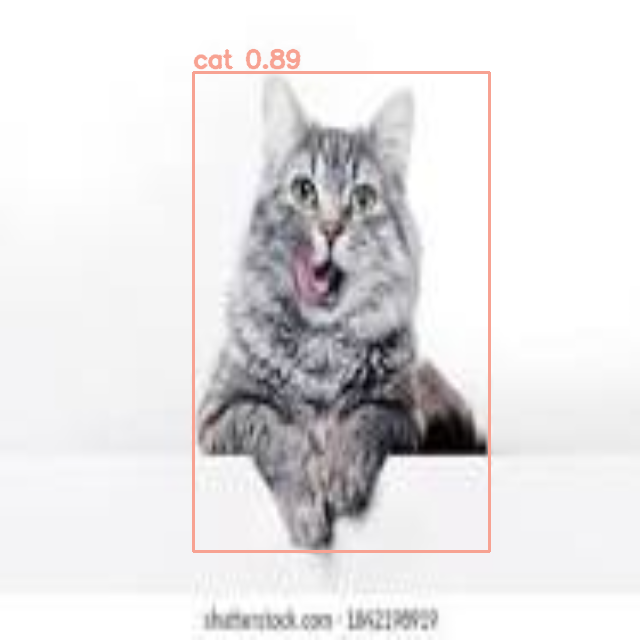

In [25]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))
MAP_LOCATION= "cpu"
def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        xmin= int(xmin.item())
        ymin= int(ymin.item())
        xmax= int(xmax.item())
        ymax= int(ymax.item())
        
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


image_url = "images.jpeg"
img = np.array(Image.open(image_url))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)
with torch.no_grad():
    model = attempt_load("yolov7.pt")#torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    model.eval()
    model.cpu()
    target_layers = [model.model[-3]]

    results = model(tensor)[0]
    pred = non_max_suppression(results, 
                                0.25, 
                                0.25)
    
    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
    for i, det in enumerate(pred):
        for *xyxy, conf, cls in reversed(det):
            print(xyxy)
            print(conf)
            print(cls)
            label = f'{names[int(cls)]} {conf:.2f}'
            print(label)
#             detections= plot_one_box(xyxy, rgb_img.copy(), label=label, color=colors[int(cls)], line_thickness=10)
    
#     boxes, colors, names = parse_detections(results)
    detections = draw_detections([xyxy], [colors[int(cls)]], [label], rgb_img.copy())
#     Image.fromarray(detections)

# # creating a object
Image.fromarray(detections)



Now lets create our CAM model and run it on the image:

output from base_cam.py:  (tensor([[[2.96203e+00, 3.48981e+00, 7.64425e+00,  ..., 6.22086e-04, 2.66637e-04, 1.36451e-03],
         [1.10410e+01, 4.74573e+00, 2.29420e+01,  ..., 6.90953e-04, 2.70732e-04, 9.65195e-04],
         [1.89071e+01, 4.99653e+00, 2.83118e+01,  ..., 7.61068e-04, 2.11610e-04, 9.00969e-04],
         ...,
         [5.48239e+02, 6.20286e+02, 2.19917e+02,  ..., 1.24874e-03, 4.06362e-04, 5.72786e-04],
         [5.80338e+02, 6.21260e+02, 2.03660e+02,  ..., 7.21292e-04, 2.62238e-04, 3.66925e-04],
         [6.24996e+02, 6.23140e+02, 2.45434e+02,  ..., 3.72476e-04, 1.62796e-04, 1.56279e-04]]], grad_fn=<CatBackward0>), [tensor([[[[[-2.60964e-01, -1.27722e-01, -4.09350e-01,  ..., -7.38181e+00, -8.22936e+00, -6.59559e+00],
           [-2.40919e-01,  1.86975e-01,  8.06414e-01,  ..., -7.27675e+00, -8.21411e+00, -6.94221e+00],
           [-2.74951e-01,  2.50433e-01,  1.19707e+00,  ..., -7.18003e+00, -8.46055e+00, -7.01114e+00],
           ...,
           [ 7.41108e-01,  3.51410e-

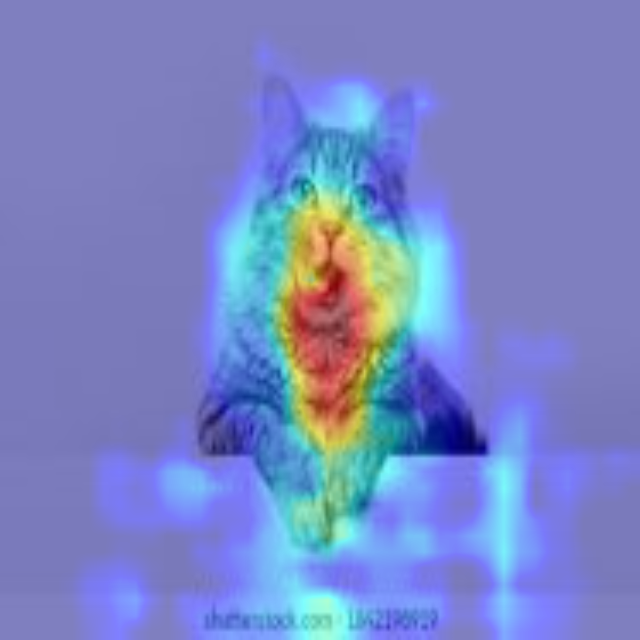

In [26]:
cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

This contains heatmaps mainly on the dogs, but not only.

Something we can do for object detection is remove heatmap data outside of the bounding boxes, and scale the heatmaps inside every bounding box.


In [7]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(renormalized_cam_image)

NameError: name 'boxes' is not defined

In [8]:
Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))

NameError: name 'renormalized_cam_image' is not defined